In [2]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# VARIABLES CONFIGURATION
experiment_id = "10-07-50"

In [9]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

client.admin.command('ping')

{'ok': 1.0}

In [16]:
db = client.test
historical_evolution_data = db.historicalEvolutionData

def convert_cost_values_to_percentages(costs):
    percentage_values = []
    start_value = costs[0]
    for i in range(0, len(costs)):
        percentage_values.append(costs[i] / start_value * 100)
    return percentage_values

def convert_to_percentages(array):
    for i in range(0, len(array)):
        array[i] = convert_cost_values_to_percentages(array[i])

def get_percentages_by_solver(solver_name):
    data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name})
    cost_data = list(map(lambda x: x["costData"], data))
    convert_to_percentages(cost_data)
    percentages = np.array(cost_data)
    return np.mean(percentages, axis=0)


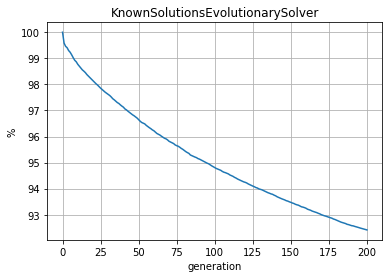

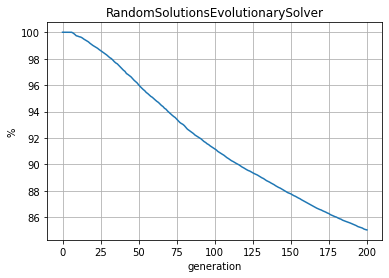

In [18]:
def create_percentage_plot(solver_name):
    fig, ax = plt.subplots()
    average_percentages = get_percentages_by_solver(solver_name)
    ax.plot(average_percentages)

    ax.set(xlabel='generation', ylabel='%',
       title= solver_name)
    ax.grid()

    plt.show()


create_percentage_plot("KnownSolutionsEvolutionarySolver")
create_percentage_plot("RandomSolutionsEvolutionarySolver")

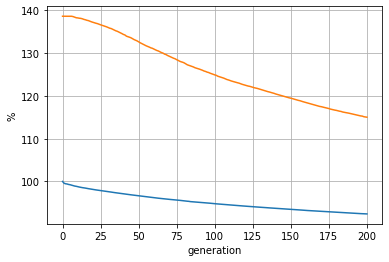

In [28]:
def cost_values_to_percentages(costs, start_value):
    percentage_values = []
    for i in range(0, len(costs)):
        percentage_values.append(costs[i] / start_value * 100)
    return percentage_values

def convert_to_percentages(solver1_array, solver2_array):
    for i in range(0, len(solver1_array)):
        if (solver1_array[i][0] <= solver2_array[i][0]):
            base_value = solver1_array[i][0]
        else:
            base_value = solver2_array[i][0]
        solver1_array[i] = cost_values_to_percentages(solver1_array[i], base_value)
        solver2_array[i] = cost_values_to_percentages(solver2_array[i], base_value)


def get_percentages_by_solver(solver_name):
    data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver_name})
    cost_data = list(map(lambda x: x["costData"], data))
    convert_to_percentages(cost_data)
    percentages = np.array(cost_data)
    return np.mean(percentages, axis=0)


def zip_solver_costs(solver1, solver2):
    solver1_data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver1})
    solver2_data = historical_evolution_data.find({"experimentId" : experiment_id, "solverName" : solver2})

    solver1_costs = list(map(lambda x: x["costData"], sorted(solver1_data, key= lambda x: x["instanceId"])))
    solver2_costs = list(map(lambda x: x["costData"], sorted(solver2_data, key= lambda x: x["instanceId"])))

    convert_to_percentages(solver1_costs, solver2_costs)

    average_solver1_percentages = np.mean(np.array(solver1_costs), axis=0)
    average_solver2_percentages = np.mean(np.array(solver2_costs), axis=0)
    return average_solver1_percentages, average_solver2_percentages

def create_solvers_comparison_plot(solver1_data, solver2_data):
    fig, ax = plt.subplots()
    ax.plot(solver1_data)
    ax.plot(solver2_data)

    ax.set(xlabel='generation', ylabel='%',
       title= "")
    ax.grid()

    plt.show()

solver1_data, solver2_data = zip_solver_costs("KnownSolutionsEvolutionarySolver", "RandomSolutionsEvolutionarySolver")
create_solvers_comparison_plot(solver1_data, solver2_data)